In [15]:
import pandas as pd
df_clean = pd.read_parquet("../data/interim/final_clean.parquet")
df_clean.head()


,row_name,clip_start,clip_end,set_num,set_num:_time,set_p1,set_p1:_time,set_p2,set_p2:_time,servicio,...,golpe_q:_time,fin_golpe,fin_golpe:_time,fin_golpe:_x,fin_golpe:_y,inicio_golpe,inicio_golpe:_time,inicio_golpe:_x,inicio_golpe:_y,__source_file
0,1º Servicio,108.058,108.788,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Arturo Coello,...,108.058,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Roterdam_CoelloTapia_NietoYanguas CSV.csv
1,1º Servicio,131.279,132.01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Arturo Coello,...,131.279,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Roterdam_CoelloTapia_NietoYanguas CSV.csv
2,1º Servicio,162.04,162.77,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Arturo Coello,...,162.04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Roterdam_CoelloTapia_NietoYanguas CSV.csv
3,1º Servicio,194.415,195.146,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Arturo Coello,...,194.415,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Roterdam_CoelloTapia_NietoYanguas CSV.csv
4,1º Servicio,214.437,215.167,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1º Servicio Arturo Coello,...,214.437,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,25_Roterdam_CoelloTapia_NietoYanguas CSV.csv


In [3]:
import pandas as pd
import numpy as np
import re

# ======================================================
# CONFIGURACIÓN
# ======================================================
RUTA = "limpios_cokiyanguas_ordenados.xlsx"  # archivo de entrada
SALIDA = "kpis_servicio_adaptado.xlsx"       # archivo de salida

# Tokens para identificar eventos de servicio
TOK_ACE = {"ace", "saque directo", "servicio ace"}
TOK_DF  = {"doble falta", "double fault"}
TOK_1S  = {"1º servicio", "primer servicio", "1er servicio", "1 servicio", "primer saque"}
TOK_2S  = {"2º servicio", "segundo servicio", "2o servicio", "2do servicio", "2 servicio"}

# ======================================================
# FUNCIONES AUXILIARES
# ======================================================
def norm(x):
    return str(x).strip().lower() if pd.notna(x) else x

def contains_any(tokens, text):
    if pd.isna(text): return False
    t = str(text).lower()
    return any(tok in t for tok in tokens)

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

# ======================================================
# 1. CARGA Y PREPROCESADO
# ======================================================
df = pd.read_excel(RUTA)
df.columns = [c.lower().strip() for c in df.columns]

# columnas existentes en tu dataset
COL_EVENTO = "row_name"
COL_JUGADOR = "jugador"
COL_WINNER = "winner"

df[COL_EVENTO] = df[COL_EVENTO].map(norm)

# ======================================================
# 2. INFERIR SERVIDOR Y PUNTO
# ======================================================
# Cada "servicio <nombre>" abre un nuevo punto
servers, point_ids = [], []
current_server, current_point = None, 0
pat = re.compile(r"^servicio\s+(.+)$")

for ev in df[COL_EVENTO].fillna(""):
    m = pat.match(ev)
    if m:
        current_server = m.group(1).strip()
        current_point += 1
    servers.append(current_server)
    point_ids.append(current_point if current_point > 0 else np.nan)

df["server"] = servers
df["point_id"] = point_ids
df = df[df["point_id"].notna()].copy()
df["point_id"] = df["point_id"].astype(int)

# ======================================================
# 3. ETIQUETAR EVENTOS DENTRO DE CADA PUNTO
# ======================================================
df["is_ace"] = df[COL_EVENTO].apply(lambda x: contains_any(TOK_ACE, x)).astype(int)
df["is_df"] = df[COL_EVENTO].apply(lambda x: contains_any(TOK_DF, x)).astype(int)
df["is_1sin"] = df[COL_EVENTO].apply(lambda x: contains_any(TOK_1S, x)).astype(int)
df["is_2sin"] = df[COL_EVENTO].apply(lambda x: contains_any(TOK_2S, x)).astype(int)

# Último ganador observado en el punto
winner_last = df.groupby("point_id")[COL_WINNER].last()

# ======================================================
# 4. RESUMIR CADA PUNTO
# ======================================================
agg_point = df.groupby("point_id").agg(
    server=("server","last"),
    has_ace=("is_ace","max"),
    has_df=("is_df","max"),
    first_serve_in=("is_1sin","max"),
    second_serve_in=("is_2sin","max")
)
agg_point["point_winner"] = winner_last

# Si hay ace, ganador = servidor
mask_ace = agg_point["has_ace"] == 1
agg_point.loc[mask_ace, "point_winner"] = agg_point.loc[mask_ace, "server"]

# ======================================================
# 5. CALCULAR KPIs DE SERVICIO POR JUGADOR
# ======================================================
srv_points_total = agg_point.groupby("server").size().rename("puntos_servicio_totales")
aces_total = agg_point.groupby("server")["has_ace"].sum().rename("aces_total")
df_total = agg_point.groupby("server")["has_df"].sum().rename("double_faults_total")
first_in = agg_point.groupby("server")["first_serve_in"].sum().rename("first_in")
second_in = agg_point.groupby("server")["second_serve_in"].sum().rename("second_in")
srv_won = (agg_point["point_winner"]==agg_point["server"]).groupby(agg_point["server"]).sum().rename("puntos_servicio_ganados")

kpi = pd.concat([srv_points_total, aces_total, df_total, first_in, second_in, srv_won], axis=1).fillna(0)
kpi["pct_1er_servicio_adentro"] = safe_div(kpi["first_in"], kpi["puntos_servicio_totales"])

# Puntos ganados con 1S y 2S
mask_1s = agg_point["first_serve_in"] == 1
mask_2s = (agg_point["first_serve_in"] == 0) & (agg_point["second_serve_in"] == 1)
pts_1s_total = mask_1s.groupby(agg_point["server"]).sum().rename("pts_1s_total")
pts_1s_won = ((agg_point["point_winner"] == agg_point["server"]) & mask_1s).groupby(agg_point["server"]).sum().rename("pts_1s_won")
pts_2s_total = mask_2s.groupby(agg_point["server"]).sum().rename("pts_2s_total")
pts_2s_won = ((agg_point["point_winner"] == agg_point["server"]) & mask_2s).groupby(agg_point["server"]).sum().rename("pts_2s_won")

kpi = kpi.join([pts_1s_total, pts_1s_won, pts_2s_total, pts_2s_won], how="left").fillna(0)
kpi["pct_puntos_ganados_1er_servicio"] = safe_div(kpi["pts_1s_won"], kpi["pts_1s_total"])
kpi["pct_puntos_ganados_2do_servicio"] = safe_div(kpi["pts_2s_won"], kpi["pts_2s_total"])

# Añadir jugador y ordenar columnas
kpi = kpi.reset_index().rename(columns={"server": "jugador_que_sirve"})
cols = [
    "jugador_que_sirve",
    "puntos_servicio_totales",
    "aces_total",
    "double_faults_total",
    "pct_1er_servicio_adentro",
    "pts_1s_total","pts_1s_won","pct_puntos_ganados_1er_servicio",
    "pts_2s_total","pts_2s_won","pct_puntos_ganados_2do_servicio"
]
kpi = kpi[cols]

# ======================================================
# 6. GUARDAR Y MOSTRAR RESULTADOS
# ======================================================

print(kpi)


  jugador_que_sirve  puntos_servicio_totales  aces_total  double_faults_total  \
0     agustín tapia                       38           0                    0   
1     arturo coello                       34           0                    0   
2       jorge nieto                       22           0                    0   
3    miguel yanguas                       44           0                    0   

   pct_1er_servicio_adentro  pts_1s_total  pts_1s_won  \
0                  1.000000            38           0   
1                  1.000000            34           0   
2                  1.000000            22           0   
3                  0.977273            43           0   

   pct_puntos_ganados_1er_servicio  pts_2s_total  pts_2s_won  \
0                              0.0             0           0   
1                              0.0             0           0   
2                              0.0             0           0   
3                              0.0             0    


🔎 COMBINACIONES ÚNICAS DE 'row_name' Y 'jugador'

               row_name        jugador  frecuencia
                  volea  Agustín Tapia         126
                  volea  Arturo Coello          96
                  globo  Agustín Tapia          74
                  volea    Jorge Nieto          70
                  volea Miguel Yanguas          69
                  reves    Jorge Nieto          61
                derecha Miguel Yanguas          59
                bandeja    Jorge Nieto          52
                  globo    Jorge Nieto          52
                  globo  Arturo Coello          47
servicio miguel yanguas Miguel Yanguas          44
            1º servicio Miguel Yanguas          43
                  punto Miguel Yanguas          43
                  reves  Agustín Tapia          41
                derecha    Jorge Nieto          39
            1º servicio  Agustín Tapia          38
                  punto  Agustín Tapia          38
 servicio agustín tapia  Agustí

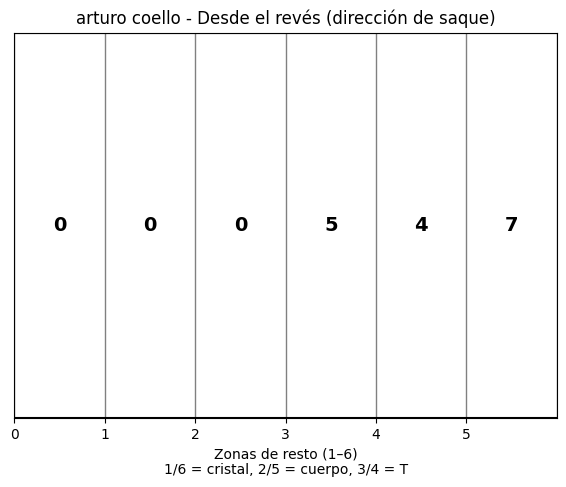

  • Desde el revés saca hacia cristal: 7 veces (43.8%)
  • Desde el revés saca hacia cuerpo: 4 veces (25.0%)
  • Desde el revés saca hacia T: 5 veces (31.2%)
  ⇒ Tiende a sacar desde el revés principalmente hacia cristal, T.



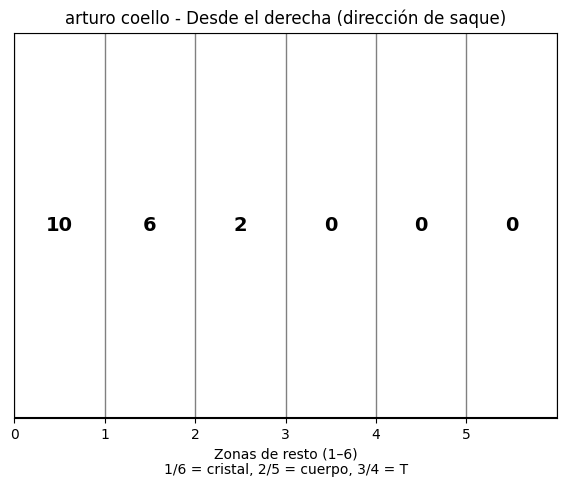

  • Desde el derecha saca hacia cristal: 10 veces (55.6%)
  • Desde el derecha saca hacia cuerpo: 6 veces (33.3%)
  • Desde el derecha saca hacia T: 2 veces (11.1%)
  ⇒ Tiende a sacar desde el derecha principalmente hacia cristal, cuerpo.


=== MIGUEL YANGUAS ===


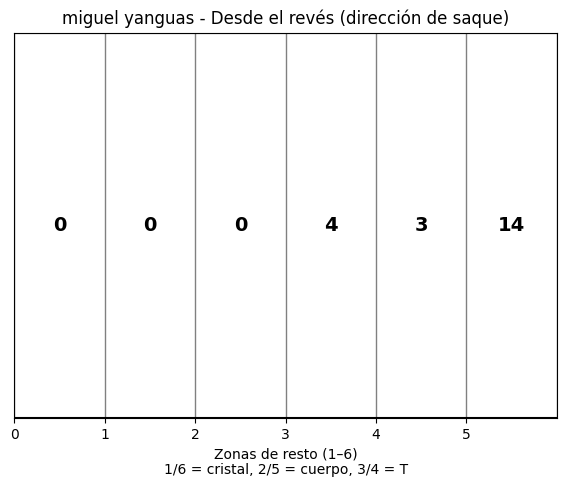

  • Desde el revés saca hacia cristal: 14 veces (66.7%)
  • Desde el revés saca hacia cuerpo: 3 veces (14.3%)
  • Desde el revés saca hacia T: 4 veces (19.0%)
  ⇒ Tiende a sacar desde el revés principalmente hacia cristal, T.



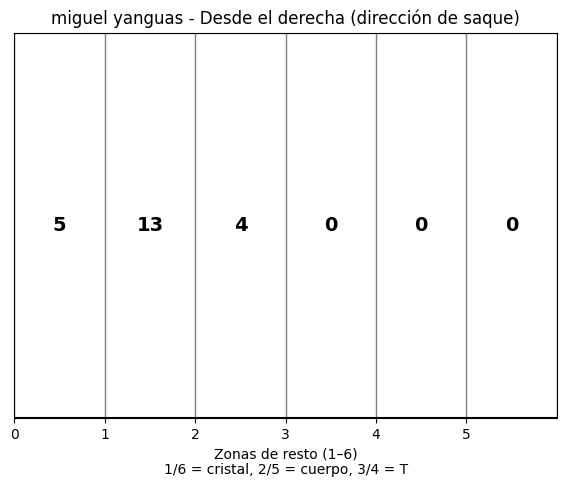

  • Desde el derecha saca hacia cristal: 5 veces (22.7%)
  • Desde el derecha saca hacia cuerpo: 13 veces (59.1%)
  • Desde el derecha saca hacia T: 4 veces (18.2%)
  ⇒ Tiende a sacar desde el derecha principalmente hacia cuerpo, cristal.


=== AGUSTÍN TAPIA ===


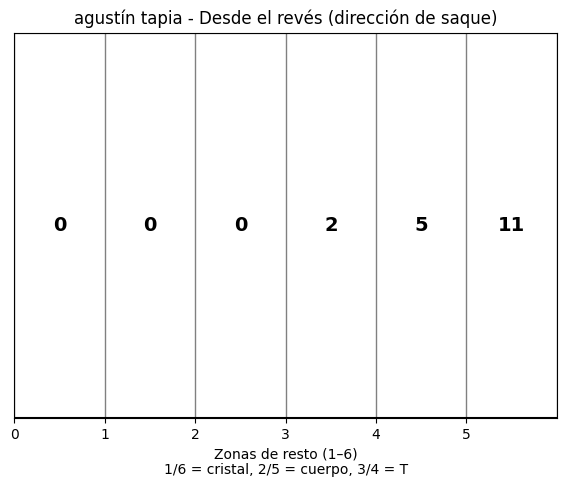

  • Desde el revés saca hacia cristal: 11 veces (61.1%)
  • Desde el revés saca hacia cuerpo: 5 veces (27.8%)
  • Desde el revés saca hacia T: 2 veces (11.1%)
  ⇒ Tiende a sacar desde el revés principalmente hacia cristal, cuerpo.



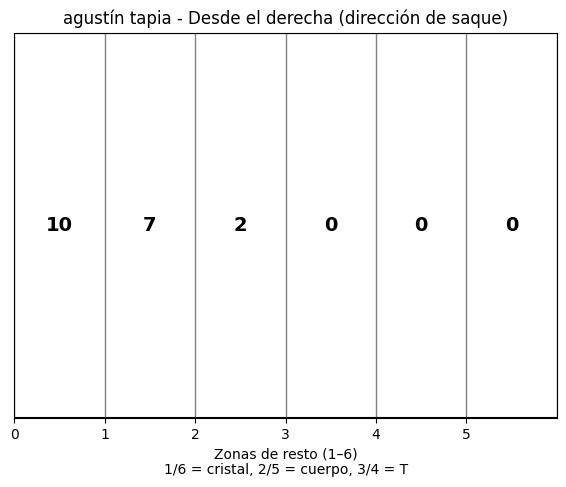

  • Desde el derecha saca hacia cristal: 10 veces (52.6%)
  • Desde el derecha saca hacia cuerpo: 7 veces (36.8%)
  • Desde el derecha saca hacia T: 2 veces (10.5%)
  ⇒ Tiende a sacar desde el derecha principalmente hacia cristal, cuerpo.


=== JORGE NIETO ===


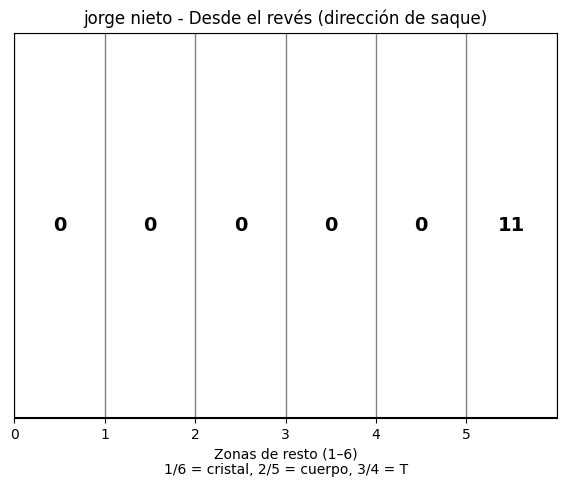

  • Desde el revés saca hacia cristal: 11 veces (100.0%)
  • Desde el revés saca hacia cuerpo: 0 veces (0.0%)
  • Desde el revés saca hacia T: 0 veces (0.0%)
  ⇒ Tiende a sacar desde el revés principalmente hacia cristal.



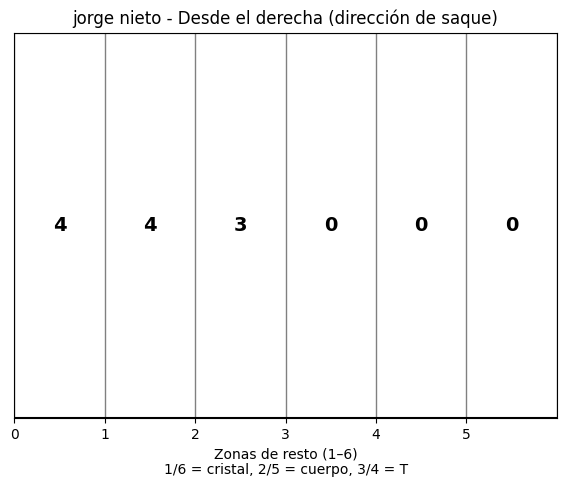

  • Desde el derecha saca hacia cristal: 4 veces (36.4%)
  • Desde el derecha saca hacia cuerpo: 4 veces (36.4%)
  • Desde el derecha saca hacia T: 3 veces (27.3%)
  ⇒ Tiende a sacar desde el derecha principalmente hacia cuerpo, cristal.



In [7]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ========================================
# CONFIGURACIÓN Y TOKENS
# ========================================
RUTA = "limpios_cokiyanguas_ordenados.xlsx"

# ========================================
# FUNCIONES AUXILIARES
# ========================================
def norm(x):
    return str(x).strip().lower() if pd.notna(x) else x

def detectar_servidor(df):
    servers, point_ids = [], []
    current_server, current_point = None, 0
    pat = re.compile(r"^\s*servicio\s+([^\-:]+)", flags=re.IGNORECASE)
    for ev in df["row_name"].fillna(""):
        m = pat.match(ev)
        if m:
            current_server = m.group(1).strip()
            current_point += 1
        servers.append(current_server)
        point_ids.append(current_point if current_point > 0 else np.nan)
    df["server"] = servers
    df["point_id"] = point_ids
    df = df[df["point_id"].notna()].copy()
    df["point_id"] = df["point_id"].astype(int)
    return df

def destino_label(zr):
    try:
        z = int(zr)
    except:
        return np.nan
    if z == 1 or z == 6:
        return "cristal"
    if z == 2 or z == 5:
        return "cuerpo"
    if z == 3 or z == 4:
        return "T"
    return np.nan

def lado_saque(zs):
    """Devuelve 'revés' si zona 1–3, 'derecha' si 4–6."""
    try:
        z = int(zs)
    except:
        return np.nan
    if z in (1,2,3):
        return "revés"
    if z in (4,5,6):
        return "derecha"
    return np.nan

# ========================================
# 1. CARGA Y PREPROCESADO
# ========================================
df = pd.read_excel(RUTA)
df.columns = [c.lower().strip() for c in df.columns]
df["row_name"] = df["row_name"].map(norm)

# ========================================
# 1.1 VER COMBINACIONES DE row_name Y jugador
# ========================================
comb = (
    df[["row_name", "jugador"]]
    .dropna()
    .value_counts()
    .reset_index(name="frecuencia")
    .sort_values(by="frecuencia", ascending=False)
)

print("\n=============================================")
print("🔎 COMBINACIONES ÚNICAS DE 'row_name' Y 'jugador'")
print("=============================================\n")
print(comb.to_string(index=False))

# Si quieres ver solo los eventos que mencionan "servicio"
comb_servicio = comb[comb["row_name"].str.contains("servicio", case=False, na=False)]
print("\n=============================================")
print("🎾 EVENTOS QUE CONTIENEN 'servicio'")
print("=============================================\n")
print(comb_servicio.to_string(index=False))

# ========================================
# 2. DETECTAR SERVIDOR Y PROCESAR DATOS
# ========================================
df = detectar_servidor(df)

agg_point = df.groupby("point_id").agg(
    server=("server","last"),
    zona_saque=("zona_saque","last"),
    zona_resto=("zona_resto","last")
).reset_index()

agg_point["destino"] = agg_point["zona_resto"].map(destino_label)
agg_point["lado_saque"] = agg_point["zona_saque"].map(lado_saque)

# ========================================
# 3. FUNCIÓN DE GRÁFICO TIPO PISTA
# ========================================
def plot_pista(jugador, lado, data):
    """Dibuja una “pista” con 6 cuadros del lado de resto y anota el número de saques dirigidos a cada uno."""
    plt.figure(figsize=(7, 5))
    ax = plt.gca()
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 6))
    ax.set_yticks([])

    # Dibujar líneas de los cuadros
    for i in range(7):
        ax.axvline(i, color='gray', lw=1)
    ax.axhline(0, color='black')
    ax.axhline(1, color='black')

    # Conteos por zona_resto (1–6)
    counts = data["zona_resto"].value_counts().reindex(range(1,7), fill_value=0)

    # Dibujar número de saques por cuadro
    for i in range(1,7):
        val = counts[i]
        ax.text(i-0.5, 0.5, str(val), ha='center', va='center', fontsize=14, weight='bold')

    ax.set_title(f"{jugador} - Desde el {lado} (dirección de saque)")
    ax.set_xlabel("Zonas de resto (1–6)\n1/6 = cristal, 2/5 = cuerpo, 3/4 = T")
    plt.show()

# ========================================
# 4. ANÁLISIS Y FRASES POR JUGADOR
# ========================================
def analizar_jugador(jugador):
    sub = agg_point[agg_point["server"] == jugador]
    if sub.empty:
        print(f"⚠️ Sin datos para {jugador}")
        return

    print(f"\n=== {jugador.upper()} ===")

    for lado in ["revés", "derecha"]:
        side_data = sub[sub["lado_saque"] == lado]
        if side_data.empty:
            print(f"  No hay saques desde el {lado}.")
            continue

        plot_pista(jugador, lado, side_data)

        # Resumen numérico por destino
        destino_counts = side_data["destino"].value_counts().reindex(["cristal","cuerpo","T"], fill_value=0)
        total = destino_counts.sum()
        for destino, n in destino_counts.items():
            pct = n / total * 100 if total else 0
            print(f"  • Desde el {lado} saca hacia {destino}: {n} veces ({pct:.1f}%)")

        top_zonas = side_data["zona_resto"].value_counts().head(2).index.tolist()
        top_destinos = [destino_label(z) for z in top_zonas]
        if len(top_destinos) > 0:
            print(f"  ⇒ Tiende a sacar desde el {lado} principalmente hacia {', '.join(top_destinos)}.")
        print()

# ========================================
# 5. EJECUCIÓN
# ========================================
for jugador in agg_point["server"].dropna().unique():
    analizar_jugador(jugador)



🎾 Agustín Tapia
         veces     %
destino             
cristal     23  57.5
cuerpo      13  32.5
T            4  10.0


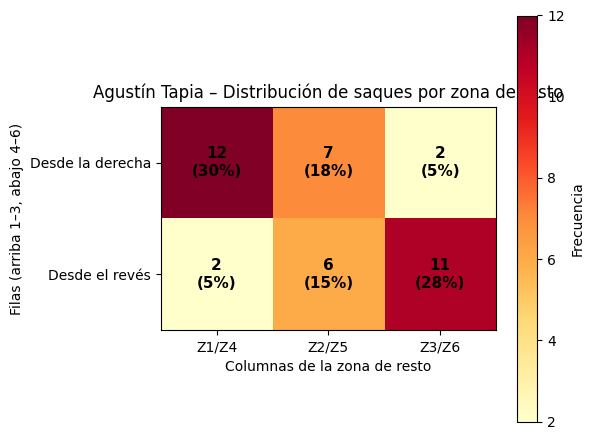


🎾 Arturo Coello
         veces     %
destino             
cristal     18  47.4
cuerpo      12  31.6
T            8  21.1


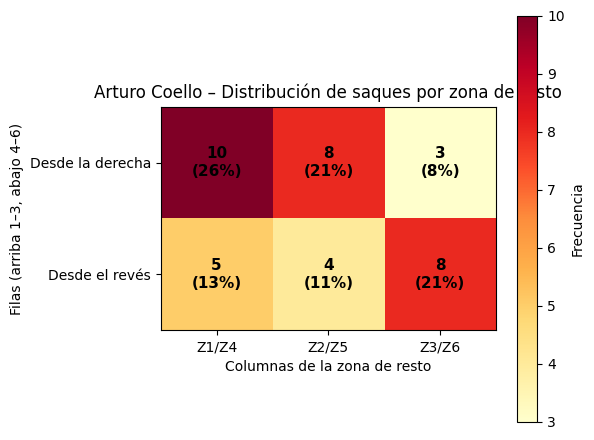


🎾 Jorge Nieto
         veces     %
destino             
cristal     16  66.7
cuerpo       5  20.8
T            3  12.5


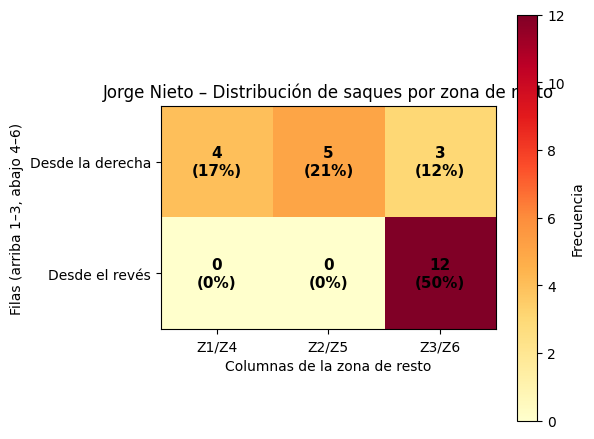


🎾 Miguel Yanguas
         veces     %
destino             
cristal     21  43.8
cuerpo      18  37.5
T            9  18.8


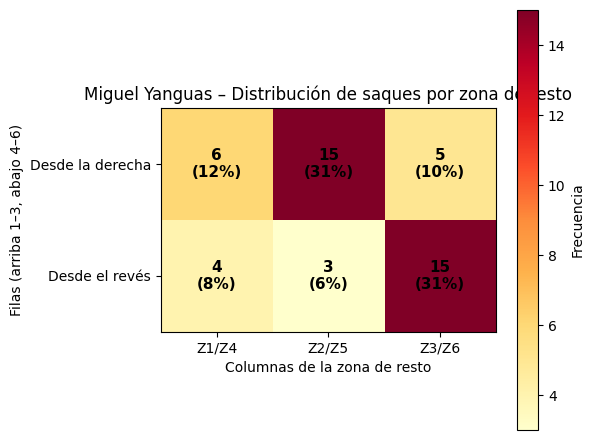

In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ========================================
# CONFIGURACIÓN
# ========================================
RUTA = "limpios_cokiyanguas_ordenados.xlsx"

# ========================================
# FUNCIONES AUXILIARES
# ========================================
def norm(x):
    """Normaliza texto: minúsculas, sin espacios extra."""
    return str(x).strip().lower() if pd.notna(x) else x

def detectar_servidor(df):
    """Detecta quién sirve y asigna identificadores de punto."""
    servers, point_ids = [], []
    current_server, current_point = None, 0
    pat = re.compile(r"^\s*servicio\s+([^\-:]+)", flags=re.IGNORECASE)
    for ev in df["row_name"].fillna(""):
        m = pat.match(ev)
        if m:
            current_server = m.group(1).strip()
            current_point += 1
        servers.append(current_server)
        point_ids.append(current_point if current_point > 0 else np.nan)
    df["server"] = servers
    df["point_id"] = point_ids
    df = df[df["point_id"].notna()].copy()
    df["point_id"] = df["point_id"].astype(int)
    return df

def destino_label(zr):
    """Traduce número de zona de resto a tipo de destino."""
    try:
        z = int(zr)
    except:
        return np.nan
    if z in (1,6): return "cristal"
    if z in (2,5): return "cuerpo"
    if z in (3,4): return "T"
    return np.nan

# ========================================
# 1. CARGA Y PREPROCESADO
# ========================================
df = pd.read_excel(RUTA)
df.columns = [c.lower().strip() for c in df.columns]
df["row_name"] = df["row_name"].map(norm)

# Detectar servidor y puntos
df = detectar_servidor(df)

# ========================================
# 2. FUNCIONES DE ANÁLISIS
# ========================================
def filtrar_saques(df, jugador):
    """Devuelve solo los saques 1º/2º de un jugador."""
    mask = (
        (df["jugador"].str.lower() == jugador.lower()) &
        (df["row_name"].str.contains(r"1º servicio|2º servicio", case=False, na=False))
    )
    return df.loc[mask, ["row_name","jugador","zona_saque","zona_resto"]].copy()

def tabla_frecuencias_destino(df, jugador):
    """Tabla con número y % de saques por destino (cristal, cuerpo, T)."""
    sub = filtrar_saques(df, jugador)
    if sub.empty:
        print(f"⚠️ Sin saques 1º/2º registrados para {jugador}")
        return pd.DataFrame()
    sub["destino"] = sub["zona_resto"].map(destino_label)
    freq = sub["destino"].value_counts().rename("veces").to_frame()
    freq["%"] = (freq["veces"] / freq["veces"].sum() * 100).round(1)
    return freq

def matriz_zonas(zonas_count):
    """Construye matriz 2x3 con conteos por zona_resto (1–6)."""
    M = np.zeros((2,3), dtype=int)
    orden = [[1,2,3],[4,5,6]]
    for i, fila in enumerate(orden):
        for j, z in enumerate(fila):
            M[i, j] = int(zonas_count.get(z, 0))
    return M, orden

def plot_heatmap_zona_resto(df, jugador):
    """Dibuja heatmap 2x3 de frecuencias por zona de resto (todos los saques)."""
    sub = filtrar_saques(df, jugador)
    if sub.empty:
        print(f"⚠️ Sin saques 1º/2º registrados para {jugador}")
        return

    counts = sub["zona_resto"].dropna().astype(int).value_counts().to_dict()
    M, _ = matriz_zonas(counts)

    plt.figure(figsize=(6, 4.5))
    ax = plt.gca()
    im = ax.imshow(M, aspect="equal", cmap="YlOrRd")

    total = M.sum()
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            c = M[i, j]
            pct = (c / total * 100) if total else 0
            ax.text(j, i, f"{c}\n({pct:.0f}%)",
                    ha="center", va="center", fontsize=11, weight="bold")

    ax.set_xticks([0,1,2], labels=["Z1/Z4","Z2/Z5","Z3/Z6"])
    ax.set_yticks([0,1], labels=["Desde la derecha","Desde el revés"])
    ax.set_xlabel("Columnas de la zona de resto")
    ax.set_ylabel("Filas (arriba 1–3, abajo 4–6)")
    ax.set_title(f"{jugador} – Distribución de saques por zona de resto")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Frecuencia")

    plt.tight_layout()
    plt.show()

# ========================================
# 3. ANÁLISIS AUTOMÁTICO POR JUGADOR
# ========================================
for jugador in sorted(df["jugador"].dropna().str.lower().unique()):
    jugador = jugador.title()
    print("\n" + "="*60)
    print(f"🎾 {jugador}")
    print("="*60)
    freq = tabla_frecuencias_destino(df, jugador)
    if not freq.empty:
        print(freq.to_string())
        plot_heatmap_zona_resto(df, jugador)


Los jugadores tienden a sacar mayoritariamente al cristal, siendo el lado más seguro para intentar que el rival falle, es un equilibrio entre "facilidad" para no fallar y provocar errores


🎾 Agustín Tapia
         saques  % saques  puntos_ganados  % puntos ganados
destino                                                    
T             4      10.0               4             100.0
cristal      23      57.5              16              69.6
cuerpo       13      32.5               7              53.8


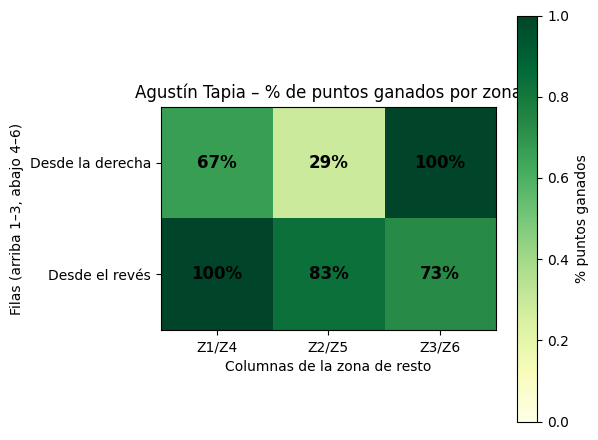


🎾 Arturo Coello
         saques  % saques  puntos_ganados  % puntos ganados
destino                                                    
T             8      21.1               6              75.0
cristal      18      47.4              12              66.7
cuerpo       12      31.6               8              66.7


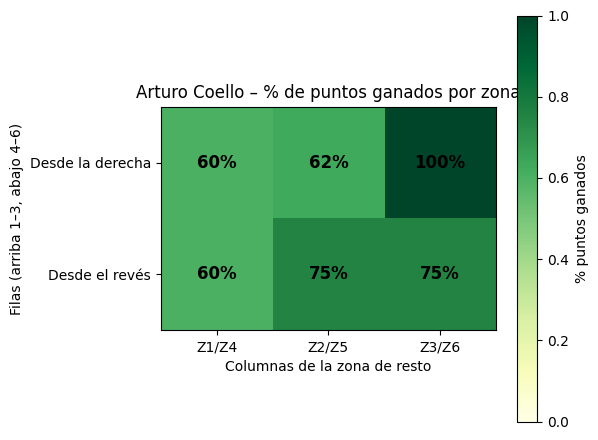


🎾 Jorge Nieto
         saques  % saques  puntos_ganados  % puntos ganados
destino                                                    
T             3      12.5               1              33.3
cristal      16      66.7               3              18.8
cuerpo        5      20.8               0               0.0


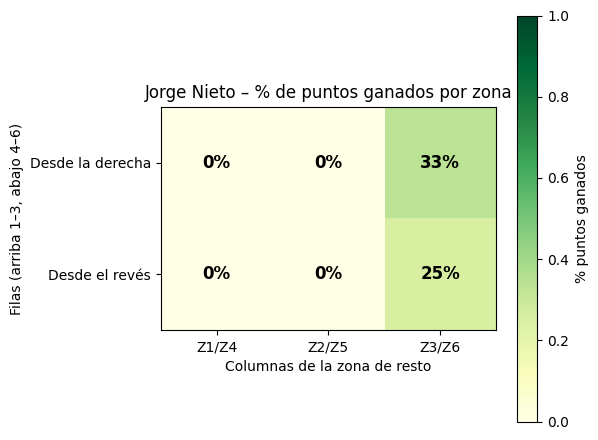


🎾 Miguel Yanguas
         saques  % saques  puntos_ganados  % puntos ganados
destino                                                    
T             9      18.8               0               0.0
cristal      21      43.8               7              33.3
cuerpo       18      37.5               3              16.7


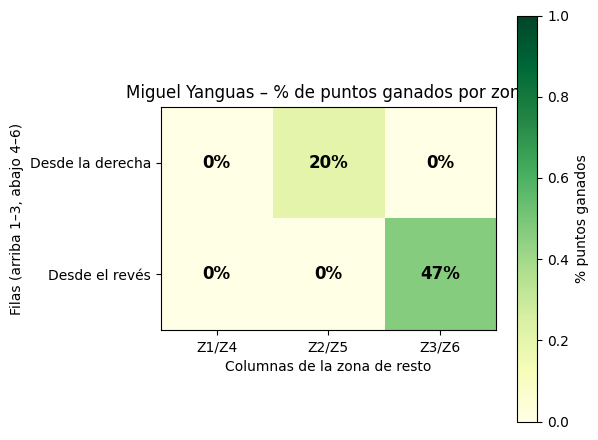

In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# ========================================
# CONFIGURACIÓN
# ========================================
RUTA = "limpios_cokiyanguas_ordenados.xlsx"

# ========================================
# FUNCIONES AUXILIARES
# ========================================
def norm(x):
    """Normaliza texto: minúsculas, sin espacios extra."""
    return str(x).strip().lower() if pd.notna(x) else x

def detectar_servidor(df):
    """Detecta quién sirve y asigna identificadores de punto."""
    servers, point_ids = [], []
    current_server, current_point = None, 0
    pat = re.compile(r"^\s*servicio\s+([^\-:]+)", flags=re.IGNORECASE)
    for ev in df["row_name"].fillna(""):
        m = pat.match(ev)
        if m:
            current_server = m.group(1).strip()
            current_point += 1
        servers.append(current_server)
        point_ids.append(current_point if current_point > 0 else np.nan)
    df = df.copy()
    df["server"] = servers
    df["point_id"] = point_ids
    df = df[df["point_id"].notna()].copy()
    df["point_id"] = df["point_id"].astype(int)
    return df

def destino_label(zr):
    """Traduce número de zona de resto a tipo de destino."""
    try:
        z = int(zr)
    except:
        return np.nan
    if z in (1,6): return "cristal"
    if z in (2,5): return "cuerpo"
    if z in (3,4): return "T"
    return np.nan

# ========================================
# PROCESAMIENTO DEL MARCADOR Y GANADOR DE PUNTO
# ========================================
def procesar_marcador_robusto(df_clean):
    """Asegura que los marcadores están bien formateados y ordenados."""
    df = df_clean.copy()
    df = df.sort_values("clip_start").reset_index(drop=True)

    for c in ["juego_p1", "juego_p2", "set_p1", "set_p2", "punto_p1", "punto_p2"]:
        if c not in df.columns:
            df[c] = 0
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    return df

def inferir_ganador_punto_preciso(df):
    """
    Detecta ganador de punto mirando cambios en punto_p1 / punto_p2.
    Si punto_p1 sube => gana pareja 1, si punto_p2 sube => gana pareja 2.
    """
    df = df.copy()
    df["punto_p1_prev"] = df["punto_p1"].shift(1).fillna(0)
    df["punto_p2_prev"] = df["punto_p2"].shift(1).fillna(0)

    ganadores = []
    for i, row in df.iterrows():
        if i == 0:
            ganadores.append(None)
            continue
        p1_prev, p2_prev = row["punto_p1_prev"], row["punto_p2_prev"]
        p1, p2 = row["punto_p1"], row["punto_p2"]
        if p1 > p1_prev:
            ganadores.append("P1")
        elif p2 > p2_prev:
            ganadores.append("P2")
        else:
            ganadores.append(None)
    df["ganador_punto"] = ganadores
    return df

def marcar_si_saque_gana(df):
    """Marca con 1 si el servidor gana el punto (según pareja)."""
    df = df.copy()
    df["server_wins"] = 0

    for pid, grupo in df.groupby("point_id"):
        # último ganador válido dentro del punto
        ganador = grupo["ganador_punto"].dropna().iloc[-1] if grupo["ganador_punto"].notna().any() else None
        servidor = grupo["server"].iloc[0]
        if pd.isna(servidor) or pd.isna(ganador):
            continue

        # 👉 Ajusta aquí los nombres reales de las parejas:
        if any(n in servidor.lower() for n in ["coello", "tapia"]) and ganador == "P1":
            df.loc[grupo.index, "server_wins"] = 1
        elif any(n in servidor.lower() for n in ["nieto", "yanguas"]) and ganador == "P2":
            df.loc[grupo.index, "server_wins"] = 1

    return df

# ========================================
# 1. CARGA Y PREPROCESADO
# ========================================
df = pd.read_excel(RUTA)
df.columns = [c.lower().strip() for c in df.columns]
df["row_name"] = df["row_name"].map(norm)

# Detectar servidor y puntos
df = detectar_servidor(df)

# Procesar marcador y ganador de punto con la nueva lógica
df = procesar_marcador_robusto(df)
df = inferir_ganador_punto_preciso(df)
df = marcar_si_saque_gana(df)

# ========================================
# 2. FUNCIONES DE ANÁLISIS
# ========================================
def filtrar_saques(df, jugador):
    """Devuelve solo los saques 1º/2º de un jugador."""
    mask = (
        (df["jugador"].str.lower() == jugador.lower()) &
        (df["row_name"].str.contains(r"1º servicio|2º servicio", case=False, na=False))
    )
    return df.loc[mask, ["row_name", "jugador", "zona_saque", "zona_resto", "server_wins"]].copy()

def tabla_saques_y_resultado(df, jugador):
    """Tabla con número de saques, % por destino y % de puntos ganados por saque."""
    sub = filtrar_saques(df, jugador)
    if sub.empty:
        print(f"⚠️ Sin saques 1º/2º registrados para {jugador}")
        return pd.DataFrame()

    sub["destino"] = sub["zona_resto"].map(destino_label)
    resumen = sub.groupby("destino", dropna=True).agg(
        saques=("destino", "count"),
        puntos_ganados=("server_wins", "sum")
    )
    total_saques = resumen["saques"].sum()
    resumen["% saques"] = (resumen["saques"] / total_saques * 100).round(1)
    resumen["% puntos ganados"] = (resumen["puntos_ganados"] / resumen["saques"] * 100).round(1)

    return resumen[["saques", "% saques", "puntos_ganados", "% puntos ganados"]]

def matriz_zonas(zonas_count):
    """Construye matriz 2x3 con conteos o tasas por zona_resto (1–6)."""
    M = np.zeros((2,3))
    orden = [[1,2,3],[4,5,6]]
    for i, fila in enumerate(orden):
        for j, z in enumerate(fila):
            M[i, j] = zonas_count.get(z, 0)
    return M, orden

def plot_heatmap_zona_resto(df, jugador):
    """Dibuja heatmap 2x3 de % de puntos ganados por zona de resto."""
    sub = filtrar_saques(df, jugador)
    if sub.empty:
        print(f"⚠️ Sin saques 1º/2º registrados para {jugador}")
        return

    sub = sub.dropna(subset=["zona_resto"])
    sub["zona_resto"] = sub["zona_resto"].astype(int)
    # Promedio de server_wins por zona
    win_rate = sub.groupby("zona_resto")["server_wins"].mean().to_dict()
    M, orden = matriz_zonas(win_rate)

    plt.figure(figsize=(6, 4.5))
    ax = plt.gca()
    im = ax.imshow(M, aspect="equal", cmap="YlGn", vmin=0, vmax=1)

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            ax.text(j, i, f"{M[i,j]*100:.0f}%",
                    ha="center", va="center", fontsize=12, weight="bold")

    ax.set_xticks([0,1,2], labels=["Z1/Z4","Z2/Z5","Z3/Z6"])
    ax.set_yticks([0,1], labels=["Desde la derecha","Desde el revés"])
    ax.set_xlabel("Columnas de la zona de resto")
    ax.set_ylabel("Filas (arriba 1–3, abajo 4–6)")
    ax.set_title(f"{jugador} – % de puntos ganados por zona")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("% puntos ganados")

    plt.tight_layout()
    plt.show()

# ========================================
# 3. ANÁLISIS AUTOMÁTICO POR JUGADOR
# ========================================
for jugador in sorted(df["jugador"].dropna().str.lower().unique()):
    jugador = jugador.title()
    print("\n" + "="*60)
    print(f"🎾 {jugador}")
    print("="*60)
    tabla = tabla_saques_y_resultado(df, jugador)
    if not tabla.empty:
        print(tabla.to_string())
        plot_heatmap_zona_resto(df, jugador)


In [59]:

import pandas as pd
import matplotlib.pyplot as plt

# Leer el CSV
df = pd.read_csv("resumen_metricas.csv")

# Crear la figura
fig, ax = plt.subplots()

# Ocultar los ejes
ax.axis('off')

# Dibujar la tabla
tabla = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')

# Ajustar formato
tabla.scale(1, 1.5)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)

# Guardar como imagen
plt.savefig("tabla.png", bbox_inches='tight', dpi=300)
plt.close()


In [61]:
df

,jugador,bola dentro,error no forzado,missed,winner,total,bola dentro_%,error no forzado_%,missed_%,winner_%,total_%
0,Agustín Tapia,248,19,3,63,333,74.5,5.7,0.9,18.9,100.0
1,Arturo Coello,231,11,6,65,313,73.8,3.5,1.9,20.8,100.0
2,Jorge Nieto,284,8,2,43,337,84.3,2.4,0.6,12.8,100.0
3,Miguel Yanguas,263,15,5,63,346,76.0,4.3,1.4,18.2,100.0


En la pareja de Coello-Tapia convierte más Coello, tiene un poco más % winner
En la pareja Yanguas-Nieto convierte más Yanguas, tiene bastante más % winner

In [3]:
import pandas as pd

In [5]:
csv_metricas_media = pd.read_csv("resumen_set_2.csv")

In [6]:
csv_metricas_media

,jugador,bola dentro,error no forzado,missed,winner,total,bola dentro_%,error no forzado_%,missed_%,winner_%,total_%,set
0,Agustín Tapia,92.00,6.00,0.00,14.00,112.00,82.14,5.36,0.00,12.50,100.0,2
1,Arturo Coello,84.00,3.00,0.00,25.00,112.00,75.00,2.68,0.00,22.32,100.0,2
2,Jorge Nieto,85.00,1.00,1.00,17.00,104.00,81.73,0.96,0.96,16.35,100.0,2
3,Miguel Yanguas,88.00,3.00,0.00,28.00,119.00,73.95,2.52,0.00,23.53,100.0,2
4,MEDIA_JUGADORES,87.25,3.25,0.25,21.00,111.75,78.20,2.88,0.24,18.68,100.0,2
5,STD_JUGADORES,3.59,2.06,0.50,6.58,6.13,4.33,1.83,0.48,5.18,0.0,2
